In [393]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import Ridge
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
import os

# EDA

### Cleaning data:

In [394]:
df = pd.read_csv("data/f1_data.csv")

df.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,TrackTemp,Rainfall,WindSpeed,RoundNumber
0,0 days 01:12:57.726000,NOR,4,0 days 00:01:57.099000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:20.913000,...,124,1.0,False,NaN,False,False,19.2,False,3.9,1
1,0 days 01:12:57.726000,DOO,7,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,124,NaN,False,NaN,True,False,19.2,False,3.9,1
2,0 days 01:12:57.726000,HAD,6,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,124,NaN,False,NaN,True,False,19.2,False,3.9,1
3,0 days 01:12:57.726000,SAI,55,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,124,NaN,False,NaN,True,False,19.2,False,3.9,1
4,0 days 01:13:00.002000,VER,1,0 days 00:01:59.392000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:20.705000,...,124,2.0,False,NaN,False,False,19.2,False,3.9,1


In [395]:
df.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate', 'TrackTemp', 'Rainfall', 'WindSpeed',
       'RoundNumber'],
      dtype='object')

In [396]:
cols_to_save = ['DriverNumber', 'LapTime', 'LapNumber', 'SpeedST', 'Compound', 'TyreLife', 'Team', 'TrackStatus', 'TrackTemp', 'Rainfall', 'WindSpeed', 'RoundNumber']
df = df[cols_to_save].copy()
df['LapTime'] = pd.to_timedelta(df['LapTime'])
df['LapTime'] = df['LapTime'].dt.total_seconds()
df['SpeedST'] = df.groupby('DriverNumber')['SpeedST'].transform(lambda x: x.ffill().bfill())

In [397]:
df.head()

,DriverNumber,LapTime,LapNumber,SpeedST,Compound,TyreLife,Team,TrackStatus,TrackTemp,Rainfall,WindSpeed,RoundNumber
0,4,117.099,1.0,227.0,INTERMEDIATE,1.0,McLaren,124,19.2,False,3.9,1
1,7,NaN,1.0,318.0,INTERMEDIATE,1.0,Alpine,124,19.2,False,3.9,1
2,6,NaN,1.0,319.0,INTERMEDIATE,1.0,Racing Bulls,124,19.2,False,3.9,1
3,55,NaN,1.0,321.0,INTERMEDIATE,1.0,Williams,124,19.2,False,3.9,1
4,1,119.392,1.0,215.0,INTERMEDIATE,1.0,Red Bull Racing,124,19.2,False,3.9,1


In [398]:
df = df.dropna()

Adding Fuellevel: later in race -> less fuel

In [399]:
max_laps = df.groupby('RoundNumber')['LapNumber'].transform('max')
df['FuelLevel'] = max_laps - df['LapNumber']
df.head()

,DriverNumber,LapTime,LapNumber,SpeedST,Compound,TyreLife,Team,TrackStatus,TrackTemp,Rainfall,WindSpeed,RoundNumber,FuelLevel
0,4,117.099,1.0,227.0,INTERMEDIATE,1.0,McLaren,124,19.2,False,3.9,1,56.0
4,1,119.392,1.0,215.0,INTERMEDIATE,1.0,Red Bull Racing,124,19.2,False,3.9,1,56.0
5,81,120.807,1.0,226.0,INTERMEDIATE,1.0,McLaren,124,19.2,False,3.9,1,56.0
6,63,124.644,1.0,207.0,INTERMEDIATE,1.0,Mercedes,124,19.2,False,3.9,1,56.0
7,16,128.480,1.0,191.0,INTERMEDIATE,1.0,Ferrari,124,19.2,False,3.9,1,56.0


In [400]:
df.dtypes

DriverNumber      int64
LapTime         float64
LapNumber       float64
SpeedST         float64
Compound         object
TyreLife        float64
Team             object
TrackStatus       int64
TrackTemp       float64
Rainfall           bool
WindSpeed       float64
RoundNumber       int64
FuelLevel       float64
dtype: object

In [401]:
df['DriverNumber'] = df['DriverNumber'].astype('category')
df['Compound'].unique()

array(['INTERMEDIATE', 'MEDIUM', 'HARD', 'SOFT'], dtype=object)

In [402]:
# deleting all laps with yellow or red flags (significantly impacts time)
df = df[df['TrackStatus'] == 1]
df['TrackStatus'].unique()

array([1])

In [403]:
quali = pd.read_csv('data/f1_quali_data.csv')
quali

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,RoundNumber
0,0 days 00:18:10.446000,NOR,4,0 days 00:01:16.003000,2.0,1.0,NaN,NaN,0 days 00:00:26.383000,0 days 00:00:17.285000,...,McLaren,0 days 00:16:54.443000,NaN,1,NaN,NaN,NaN,False,True,1
1,0 days 00:23:24.968000,NOR,4,0 days 00:01:15.912000,5.0,2.0,NaN,NaN,0 days 00:00:26.463000,0 days 00:00:17.116000,...,McLaren,0 days 00:22:09.056000,NaN,1,NaN,NaN,NaN,False,True,1
2,0 days 00:42:08.476000,NOR,4,0 days 00:01:15.556000,10.0,4.0,NaN,NaN,0 days 00:00:26.104000,0 days 00:00:17.122000,...,McLaren,0 days 00:40:52.920000,NaN,1,NaN,NaN,NaN,False,True,1
3,0 days 00:53:23.470000,NOR,4,0 days 00:01:15.415000,13.0,5.0,NaN,NaN,0 days 00:00:26.194000,0 days 00:00:17.030000,...,McLaren,0 days 00:52:08.055000,NaN,1,NaN,NaN,NaN,False,True,1
4,0 days 01:03:42.907000,NOR,4,0 days 00:01:15.921000,16.0,6.0,NaN,NaN,0 days 00:00:26.127000,0 days 00:00:17.057000,...,McLaren,0 days 01:02:26.986000,NaN,1,NaN,NaN,NaN,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,0 days 00:22:23.710000,GAS,10,0 days 00:01:23.522000,5.0,2.0,NaN,NaN,0 days 00:00:17.076000,0 days 00:00:36.200000,...,Alpine,0 days 00:21:00.188000,NaN,1,NaN,NaN,NaN,False,True,24
2156,0 days 00:31:40.354000,GAS,10,0 days 00:01:23.468000,8.0,3.0,NaN,NaN,0 days 00:00:17.050000,0 days 00:00:36.078000,...,Alpine,0 days 00:30:16.886000,NaN,1,NaN,NaN,NaN,False,True,24
2157,0 days 00:16:52.441000,COL,43,0 days 00:01:24.468000,2.0,1.0,NaN,NaN,0 days 00:00:17.309000,0 days 00:00:36.477000,...,Alpine,0 days 00:15:27.973000,NaN,1,NaN,NaN,NaN,False,True,24
2158,0 days 00:22:58.066000,COL,43,0 days 00:01:23.947000,5.0,2.0,NaN,NaN,0 days 00:00:17.138000,0 days 00:00:36.356000,...,Alpine,0 days 00:21:34.119000,NaN,1,NaN,NaN,NaN,False,True,24


Adding target = Laptime/Qualibest, because comparing the Laptimes on different fields would be unfair.

In [404]:
quali['LapTime'] = pd.to_timedelta(quali['LapTime'])
quali['LapTime'] = quali['LapTime'].dt.total_seconds()
best_quali = quali.groupby('RoundNumber')['LapTime'].min().rename('QualiBest')
best_quali

RoundNumber
1      75.096
2      90.641
3      86.983
4      89.841
5      87.294
6      86.204
7      74.670
8      69.954
9      71.546
10     70.899
11     63.971
12     84.892
13    100.562
14     74.890
15     68.662
16     78.792
17    101.117
18     89.158
19     92.510
20     75.586
21     69.511
23     79.387
24     82.207
Name: QualiBest, dtype: float64

In [405]:
df = df.merge(best_quali, on='RoundNumber', how='left')
df['Target'] = df['LapTime'] / df['QualiBest']

In [406]:
df = df.sort_values(by=['RoundNumber', 'LapNumber', 'DriverNumber'])
df

,DriverNumber,LapTime,LapNumber,SpeedST,Compound,TyreLife,Team,TrackStatus,TrackTemp,Rainfall,WindSpeed,RoundNumber,FuelLevel,QualiBest,Target
1,1,96.830,8.0,245.0,INTERMEDIATE,8.0,Red Bull Racing,1,19.1,False,3.4,1,49.0,75.096,1.289416
0,4,96.278,8.0,276.0,INTERMEDIATE,8.0,McLaren,1,19.1,False,3.4,1,49.0,75.096,1.282066
13,5,100.265,8.0,242.0,INTERMEDIATE,8.0,Kick Sauber,1,19.1,False,3.4,1,49.0,75.096,1.335158
8,10,98.441,8.0,232.0,INTERMEDIATE,8.0,Alpine,1,19.1,False,3.4,1,49.0,75.096,1.310869
12,12,98.729,8.0,240.0,INTERMEDIATE,8.0,Mercedes,1,19.1,False,3.4,1,49.0,75.096,1.314704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21532,44,89.511,58.0,310.0,MEDIUM,27.0,Ferrari,1,29.0,False,0.8,24,0.0,82.207,1.088849
21537,55,90.046,58.0,316.0,HARD,40.0,Williams,1,29.0,False,0.8,24,0.0,82.207,1.095357
21529,63,88.853,58.0,312.0,HARD,44.0,Mercedes,1,29.0,False,0.8,24,0.0,82.207,1.080845
21525,81,88.074,58.0,315.0,MEDIUM,17.0,McLaren,1,29.0,False,0.8,24,0.0,82.207,1.071369


In [407]:
df = df.drop(columns='TrackStatus')
# first lap of the race is abnormally slow so we will get rid of it
df = df[df['LapNumber'] > 1].copy()

In [408]:
df["Target"].describe()
df.sort_values("Target", ascending=False).head(20)

,DriverNumber,LapTime,LapNumber,SpeedST,Compound,TyreLife,Team,TrackTemp,Rainfall,WindSpeed,RoundNumber,FuelLevel,QualiBest,Target
16391,44,128.668,61.0,189.0,SOFT,18.0,Ferrari,33.6,False,1.4,18,1.0,89.158,1.443146
16,87,102.054,8.0,218.0,INTERMEDIATE,4.0,Haas F1 Team,19.1,False,3.4,1,49.0,75.096,1.358981
4385,5,117.049,30.0,181.0,HARD,7.0,Kick Sauber,36.0,False,1.1,6,27.0,86.204,1.357814
458,22,100.978,46.0,256.0,MEDIUM,13.0,Racing Bulls,19.3,True,1.8,1,11.0,75.096,1.344652
15,30,100.582,8.0,230.0,INTERMEDIATE,7.0,Red Bull Racing,19.1,False,3.4,1,49.0,75.096,1.339379
14,31,100.522,8.0,217.0,INTERMEDIATE,4.0,Haas F1 Team,19.1,False,3.4,1,49.0,75.096,1.338580
13,5,100.265,8.0,242.0,INTERMEDIATE,8.0,Kick Sauber,19.1,False,3.4,1,49.0,75.096,1.335158
462,30,99.457,46.0,263.0,MEDIUM,13.0,Red Bull Racing,19.3,True,1.8,1,11.0,75.096,1.324398
10154,23,111.991,11.0,310.0,INTERMEDIATE,11.0,Williams,23.3,True,1.1,12,41.0,84.892,1.319217
11,27,98.959,8.0,230.0,INTERMEDIATE,8.0,Kick Sauber,19.1,False,3.4,1,49.0,75.096,1.317767


Checking and deleting outliers:

In [409]:
num_cols = ["LapTime","Target","SpeedST","TyreLife","TrackTemp","WindSpeed","FuelLevel","QualiBest","LapNumber"]
print(df[num_cols].describe(percentiles=[.001,.01,.05,.5,.95,.99,.999]).T)

             count        mean        std         min        0.1%          1%  \
LapTime    21315.0   87.660249  10.555803   67.924000   68.759512   69.960000   
Target     21315.0    1.094949   0.037668    1.022459    1.029708    1.038367   
SpeedST    21315.0  305.748815  16.880149  181.000000  229.000000  268.000000   
TyreLife   21315.0   15.946986   9.964053    1.000000    2.000000    2.000000   
TrackTemp  21315.0   35.735515   9.436354   18.700000   18.700000   19.100000   
WindSpeed  21315.0    1.712944   0.827793    0.000000    0.000000    0.400000   
FuelLevel  21315.0   29.539057  17.995313    0.000000    0.000000    0.000000   
QualiBest  21315.0   80.133592   9.897922   63.971000   63.971000   63.971000   
LapNumber  21315.0   32.163688  17.739186    2.000000    2.000000    2.000000   

                   5%         50%         95%         99%       99.9%  \
LapTime     73.345700   84.889000  106.155300  109.561620  124.932470   
Target       1.052879    1.089031    1.1597

In [410]:
df_pre_shape = df.shape
df = df[df["Target"] <= 1.30]
df = df[df["SpeedST"] >= 240]
print(df_pre_shape, "->", df.shape)

(21315, 14) -> (21267, 14)


In [411]:
df['Rainfall'] = df['Rainfall'].astype(int)

### Correlation plots 

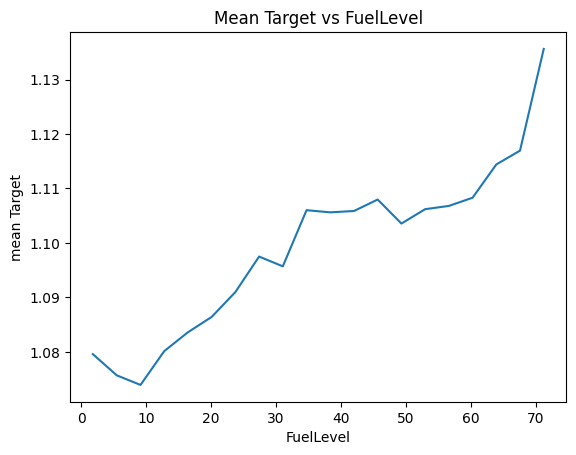

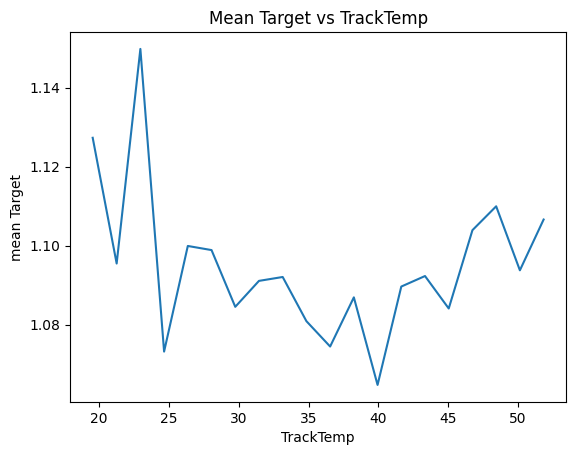

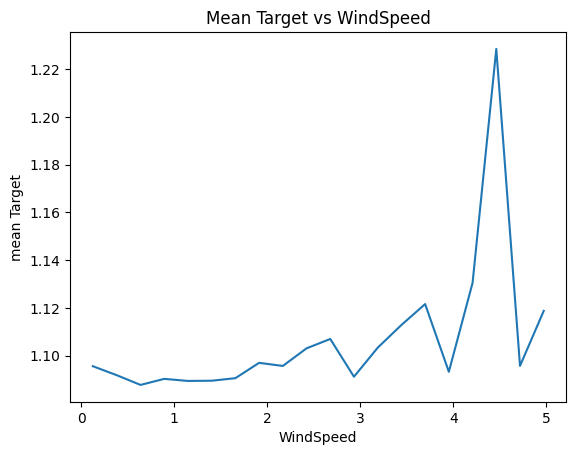

In [412]:
def trend(df, xcol, ycol="Target", bins=20, title=None):
    b = pd.cut(df[xcol], bins=bins)
    g = df.groupby(b, observed=True)[ycol].agg(["mean","count"])
    x = b.cat.categories.mid

    plt.figure()
    plt.plot(x, g["mean"].values)
    plt.title(f"Mean {ycol} vs {xcol}")
    plt.xlabel(xcol)
    plt.ylabel(f"mean {ycol}")
    plt.show()

trend(df, "FuelLevel")
trend(df, "TrackTemp")
trend(df, "WindSpeed")  

           FuelLevel  LapNumber   SpeedST  TyreLife  TrackTemp  WindSpeed  \
FuelLevel   1.000000  -0.897419 -0.104661 -0.414631   0.201299   0.184018   
LapNumber  -0.897419   1.000000 -0.048162  0.455880  -0.005529  -0.168451   
SpeedST    -0.104661  -0.048162  1.000000 -0.055109   0.131183   0.027950   
TyreLife   -0.414631   0.455880 -0.055109  1.000000  -0.022240  -0.080409   
TrackTemp   0.201299  -0.005529  0.131183 -0.022240   1.000000   0.033960   
WindSpeed   0.184018  -0.168451  0.027950 -0.080409   0.033960   1.000000   
Target      0.486972  -0.344533 -0.291239 -0.039822   0.120949   0.157229   

             Target  
FuelLevel  0.486972  
LapNumber -0.344533  
SpeedST   -0.291239  
TyreLife  -0.039822  
TrackTemp  0.120949  
WindSpeed  0.157229  
Target     1.000000  


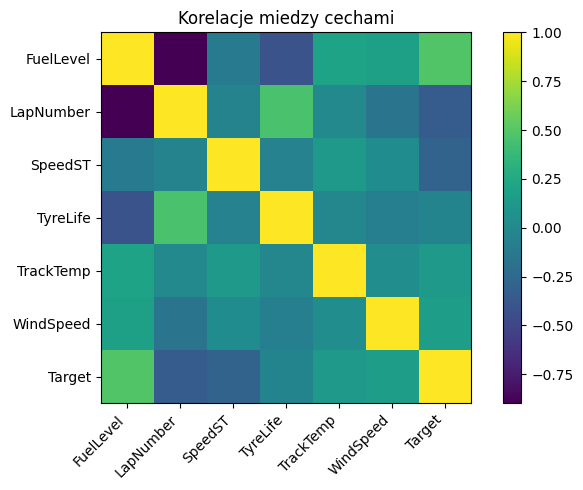

In [413]:
cols = ["FuelLevel","LapNumber","SpeedST","TyreLife","TrackTemp","WindSpeed","Target"]
C = df[cols].corr(method="spearman", numeric_only=True)
print(C)

plt.figure(figsize=(7,5))
plt.imshow(C, interpolation="nearest")
plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
plt.yticks(range(len(cols)), cols)
plt.colorbar()
plt.title("Korelacje miedzy cechami")
plt.tight_layout()
plt.show()

In [414]:
def per_round(df, col):
    out = []
    for rnd, g in df.groupby("RoundNumber"):
        r = g[[col, "Target"]].corr(method="spearman").iloc[0,1]
        out.append((rnd, r))
    return pd.DataFrame(out, columns=["RoundNumber", "Spearman"]).dropna()

for c in ["FuelLevel","SpeedST","TrackTemp","WindSpeed"]:
    t = per_round(df, c)
    print(c, "median:", t["Spearman"].median(), "mean:", t["Spearman"].mean(), "n_rounds:", len(t))

FuelLevel median: 0.6258454348319443 mean: 0.6217403848793466 n_rounds: 23
SpeedST median: 0.016608445711898873 mean: -0.017126816618609434 n_rounds: 23
TrackTemp median: 0.42946109378181185 mean: 0.3996282764952461 n_rounds: 23
WindSpeed median: 0.09359190134061518 mean: 0.07722906814992685 n_rounds: 23


# Baseline

In [415]:
# elementary baseline: always predict mean of target
y = df["Target"].values
X = df.drop(columns=["LapTime", "Target", "QualiBest", "RoundNumber"], errors="ignore")

groups = df["RoundNumber"].values
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

qb_test = df.iloc[test_idx]["QualiBest"].values
lt_test = df.iloc[test_idx]["LapTime"].values

mean_tr = y_train.mean()

pred_base_target = np.full_like(y_test, mean_tr)
print("Baseline MAE:", mean_absolute_error(y_test, pred_base_target))

pred_base_laptime = pred_base_target * qb_test
print("Baseline MAE (LapTime) [s]:", mean_absolute_error(lt_test, pred_base_laptime))

Baseline MAE: 0.03593444964691846
Baseline MAE (LapTime) [s]: 2.7199061467546986


In [416]:
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
])

ridge = Pipeline([
    ("pre", pre),
    ("model", Ridge(alpha=1.0, random_state=42))
])
ridge.fit(X_train, y_train)
pred_r = ridge.predict(X_test)
print("Ridge MAE:", mean_absolute_error(y_test, pred_r))

lt_pred = pred_r * qb_test
print("Ridge MAE(LapTime) [s]:", mean_absolute_error(lt_test, lt_pred))

Ridge MAE: 0.02097895233762879
Ridge MAE(LapTime) [s]: 1.5792789565231038


In [417]:
from sklearn.model_selection import train_test_split

X2 = df.drop(columns=["LapTime","Target","QualiBest","RoundNumber"], errors="ignore")
y2 = df["Target"].values

Xtr, Xte, ytr, yte = train_test_split(X2, y2, test_size=0.2, random_state=42)
ridge.fit(Xtr, ytr)
pred = ridge.predict(Xte)
print("Random split MAE:", mean_absolute_error(yte, pred))
print("Group split  MAE:", mean_absolute_error(y_test, pred_r))

Random split MAE: 0.013234109373744309
Group split  MAE: 0.02097895233762879


# Feature engineering

During the testing phase we will divide our dataset into training and testing set. For training we will take first 19 rounds, we will test on the other 5. Ultimately we will introduce Cross Validation.

In [418]:
df_train = df[df['RoundNumber'] < 20].copy()
df_test = df[df['RoundNumber'] >= 20].copy()

In [419]:
df_train

,DriverNumber,LapTime,LapNumber,SpeedST,Compound,TyreLife,Team,TrackTemp,Rainfall,WindSpeed,RoundNumber,FuelLevel,QualiBest,Target
1,1,96.830,8.0,245.0,INTERMEDIATE,8.0,Red Bull Racing,19.1,0,3.4,1,49.0,75.096,1.289416
0,4,96.278,8.0,276.0,INTERMEDIATE,8.0,McLaren,19.1,0,3.4,1,49.0,75.096,1.282066
2,81,97.251,8.0,257.0,INTERMEDIATE,8.0,McLaren,19.1,0,3.4,1,49.0,75.096,1.295022
18,1,94.315,9.0,258.0,INTERMEDIATE,9.0,Red Bull Racing,19.1,0,2.5,1,48.0,75.096,1.255926
17,4,94.638,9.0,281.0,INTERMEDIATE,9.0,McLaren,19.1,0,2.5,1,48.0,75.096,1.260227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17338,31,99.687,56.0,307.0,MEDIUM,32.0,Haas F1 Team,44.9,0,2.0,19,0.0,92.510,1.077581
17327,44,103.194,56.0,306.0,SOFT,27.0,Ferrari,44.9,0,2.0,19,0.0,92.510,1.115490
17329,63,99.181,56.0,308.0,SOFT,26.0,Mercedes,44.9,0,2.0,19,0.0,92.510,1.072111
17328,81,99.042,56.0,308.0,SOFT,29.0,McLaren,44.9,0,2.0,19,0.0,92.510,1.070609


In [420]:
median_targets = df_train.groupby('DriverNumber')['Target'].median()
df_train.loc[:, 'DriverPower'] = df_train['DriverNumber'].map(median_targets)
df_test.loc[:, 'DriverPower'] = df_test['DriverNumber'].map(median_targets)

/var/folders/xd/zfsynllx73dfy82g1byyz0wr0000gn/T/ipykernel_38368/2244325674.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_targets = df_train.groupby('DriverNumber')['Target'].median()


In [421]:
df_train

,DriverNumber,LapTime,LapNumber,SpeedST,Compound,TyreLife,Team,TrackTemp,Rainfall,WindSpeed,RoundNumber,FuelLevel,QualiBest,Target,DriverPower
1,1,96.830,8.0,245.0,INTERMEDIATE,8.0,Red Bull Racing,19.1,0,3.4,1,49.0,75.096,1.289416,1.076045
0,4,96.278,8.0,276.0,INTERMEDIATE,8.0,McLaren,19.1,0,3.4,1,49.0,75.096,1.282066,1.076761
2,81,97.251,8.0,257.0,INTERMEDIATE,8.0,McLaren,19.1,0,3.4,1,49.0,75.096,1.295022,1.077154
18,1,94.315,9.0,258.0,INTERMEDIATE,9.0,Red Bull Racing,19.1,0,2.5,1,48.0,75.096,1.255926,1.076045
17,4,94.638,9.0,281.0,INTERMEDIATE,9.0,McLaren,19.1,0,2.5,1,48.0,75.096,1.260227,1.076761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17338,31,99.687,56.0,307.0,MEDIUM,32.0,Haas F1 Team,44.9,0,2.0,19,0.0,92.510,1.077581,1.096348
17327,44,103.194,56.0,306.0,SOFT,27.0,Ferrari,44.9,0,2.0,19,0.0,92.510,1.115490,1.081338
17329,63,99.181,56.0,308.0,SOFT,26.0,Mercedes,44.9,0,2.0,19,0.0,92.510,1.072111,1.082307
17328,81,99.042,56.0,308.0,SOFT,29.0,McLaren,44.9,0,2.0,19,0.0,92.510,1.070609,1.077154


In [422]:
teams_median = df_train.groupby('Team')['Target'].median()
df_train.loc[:, 'TeamPace'] = df_train['Team'].map(teams_median)
df_test.loc[:, 'TeamPace'] = df_test['Team'].map(teams_median)
df_train = df_train.drop(columns='Team')
df_test = df_test.drop(columns='Team')

In [423]:
cat = ['Compound']
df_train.drop(columns=cat).corr()['Target'].sort_values(ascending=False)

Target          1.000000
Rainfall        0.368297
FuelLevel       0.319082
DriverPower     0.166411
WindSpeed       0.157587
TeamPace        0.147213
LapTime         0.012853
DriverNumber    0.004130
TyreLife       -0.037994
TrackTemp      -0.118999
RoundNumber    -0.155314
LapNumber      -0.246556
QualiBest      -0.269284
SpeedST        -0.356408
Name: Target, dtype: float64

In [424]:
df_train.columns

Index(['DriverNumber', 'LapTime', 'LapNumber', 'SpeedST', 'Compound',
       'TyreLife', 'TrackTemp', 'Rainfall', 'WindSpeed', 'RoundNumber',
       'FuelLevel', 'QualiBest', 'Target', 'DriverPower', 'TeamPace'],
      dtype='object')

In [425]:
df_train_eval = pd.get_dummies(df_train, columns=['Compound'])
df_test_eval = pd.get_dummies(df_test, columns=['Compound'])

In [426]:
col_to_drop = ['LapTime', 'DriverNumber', 'RoundNumber', 'LapNumber', 'Target', 'QualiBest']
X_train = df_train_eval.drop(columns=col_to_drop)
X_test = df_test_eval.drop(columns=col_to_drop)
y_train = df_train_eval['Target']
y_test = df_test_eval['Target']
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [427]:
model = RandomForestRegressor(
    n_estimators=100, 
    min_samples_leaf=10,
    max_depth=15,
    n_jobs=-1,
    max_features='sqrt',
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = y_pred * df_test_eval['QualiBest']
mean_absolute_error(df_test_eval['LapTime'], y_pred)

1.077619386493059

Next we must address track diversity. Different tracks influence tyres differently, and have different length. We've prepared the dataset describing all tracks in 2025 calendar. For each track we have its length, what hardness are the different compounds (1-6) and columns: Traction, Abrasion, TrackEvolution, TyreStress, Lateral, Downforce. These values are important to the model, as they allow the model to understand differences in tyre degredation and speed on different tracks. Data was taken from official Pirelli information.

In [428]:
tracks = pd.read_csv('data/track_metadata_2025.csv')
tracks = tracks.drop(columns='Location')

In [429]:
tyres = tracks[['RoundNumber', 'C_SOFT', 'C_MEDIUM', 'C_HARD']]
tyres

,RoundNumber,C_SOFT,C_MEDIUM,C_HARD
0,1,5,4,3
1,2,4,3,2
2,3,3,2,1
3,4,3,2,1
4,5,5,4,3
5,6,5,4,3
6,7,6,5,4
7,8,6,5,4
8,9,3,2,1
9,10,6,5,4


In [430]:
df_train['C_INTERMEDIATE'] = (df_train['Compound'] == 'INTERMEDIATE').astype(int)
df_test['C_INTERMEDIATE'] = (df_test['Compound'] == 'INTERMEDIATE').astype(int)

In [431]:
df_train = pd.merge(df_train, tracks, how='left', on='RoundNumber')
df_test = pd.merge(df_test, tracks, how='left', on='RoundNumber')

In [432]:
df_train

,DriverNumber,LapTime,LapNumber,SpeedST,Compound,TyreLife,TrackTemp,Rainfall,WindSpeed,RoundNumber,...,Length,Traction,Abrasion,TrackEvolution,TyreStress,Lateral,Downforce,C_HARD,C_MEDIUM,C_SOFT
0,1,96.830,8.0,245.0,INTERMEDIATE,8.0,19.1,0,3.4,1,...,5278,2,2,3,3,3,3,3,4,5
1,4,96.278,8.0,276.0,INTERMEDIATE,8.0,19.1,0,3.4,1,...,5278,2,2,3,3,3,3,3,4,5
2,81,97.251,8.0,257.0,INTERMEDIATE,8.0,19.1,0,3.4,1,...,5278,2,2,3,3,3,3,3,4,5
3,1,94.315,9.0,258.0,INTERMEDIATE,9.0,19.1,0,2.5,1,...,5278,2,2,3,3,3,3,3,4,5
4,4,94.638,9.0,281.0,INTERMEDIATE,9.0,19.1,0,2.5,1,...,5278,2,2,3,3,3,3,3,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17122,31,99.687,56.0,307.0,MEDIUM,32.0,44.9,0,2.0,19,...,5513,4,3,4,4,4,4,1,3,4
17123,44,103.194,56.0,306.0,SOFT,27.0,44.9,0,2.0,19,...,5513,4,3,4,4,4,4,1,3,4
17124,63,99.181,56.0,308.0,SOFT,26.0,44.9,0,2.0,19,...,5513,4,3,4,4,4,4,1,3,4
17125,81,99.042,56.0,308.0,SOFT,29.0,44.9,0,2.0,19,...,5513,4,3,4,4,4,4,1,3,4


In [433]:
def map_compound(df_to_map):
    df = df_to_map.copy()
    conditions = [
        df['Compound'] == 'SOFT',
        df['Compound'] == 'MEDIUM',
        df['Compound'] == 'HARD'
    ]

    choices = [
        df['C_SOFT'],
        df['C_MEDIUM'],
        df['C_HARD']
    ]

    df['CompoundRating'] = np.select(conditions, choices, default=0)
    return df['CompoundRating']

df_train['CompoundRating'] = map_compound(df_train)
df_test['CompoundRating'] = map_compound(df_test)
df_train

,DriverNumber,LapTime,LapNumber,SpeedST,Compound,TyreLife,TrackTemp,Rainfall,WindSpeed,RoundNumber,...,Traction,Abrasion,TrackEvolution,TyreStress,Lateral,Downforce,C_HARD,C_MEDIUM,C_SOFT,CompoundRating
0,1,96.830,8.0,245.0,INTERMEDIATE,8.0,19.1,0,3.4,1,...,2,2,3,3,3,3,3,4,5,0
1,4,96.278,8.0,276.0,INTERMEDIATE,8.0,19.1,0,3.4,1,...,2,2,3,3,3,3,3,4,5,0
2,81,97.251,8.0,257.0,INTERMEDIATE,8.0,19.1,0,3.4,1,...,2,2,3,3,3,3,3,4,5,0
3,1,94.315,9.0,258.0,INTERMEDIATE,9.0,19.1,0,2.5,1,...,2,2,3,3,3,3,3,4,5,0
4,4,94.638,9.0,281.0,INTERMEDIATE,9.0,19.1,0,2.5,1,...,2,2,3,3,3,3,3,4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17122,31,99.687,56.0,307.0,MEDIUM,32.0,44.9,0,2.0,19,...,4,3,4,4,4,4,1,3,4,3
17123,44,103.194,56.0,306.0,SOFT,27.0,44.9,0,2.0,19,...,4,3,4,4,4,4,1,3,4,4
17124,63,99.181,56.0,308.0,SOFT,26.0,44.9,0,2.0,19,...,4,3,4,4,4,4,1,3,4,4
17125,81,99.042,56.0,308.0,SOFT,29.0,44.9,0,2.0,19,...,4,3,4,4,4,4,1,3,4,4


In [434]:
df_train = df_train.drop(columns=['C_HARD', 'C_MEDIUM', 'C_SOFT', 'Compound'])
df_test = df_test.drop(columns=['C_HARD', 'C_MEDIUM', 'C_SOFT', 'Compound'])

In [435]:
df_train[['Length', 'Traction', 'Abrasion', 'TrackEvolution', 'TyreStress', 'Lateral', 'Downforce', 'CompoundRating', 'Target']].corr()['Target']

Length           -0.153204
Traction         -0.209839
Abrasion          0.083242
TrackEvolution   -0.361372
TyreStress        0.098765
Lateral           0.214855
Downforce         0.251570
CompoundRating   -0.463420
Target            1.000000
Name: Target, dtype: float64

In [436]:
df_train.corr()['Target'].sort_values(ascending=False)

Target            1.000000
C_INTERMEDIATE    0.769402
Rainfall          0.368297
FuelLevel         0.319082
Downforce         0.251570
Lateral           0.214855
DriverPower       0.166411
WindSpeed         0.157587
TeamPace          0.147213
TyreStress        0.098765
Abrasion          0.083242
LapTime           0.012853
DriverNumber      0.004130
TyreLife         -0.037994
TrackTemp        -0.118999
Length           -0.153204
RoundNumber      -0.155314
Traction         -0.209839
LapNumber        -0.246556
QualiBest        -0.269284
SpeedST          -0.356408
TrackEvolution   -0.361372
CompoundRating   -0.463420
Name: Target, dtype: float64

In [437]:
df_train_eval = df_train.copy()
df_test_eval = df_test.copy()

In [438]:
col_to_drop = ['LapTime', 'DriverNumber', 'RoundNumber', 'LapNumber', 'Target', 'QualiBest']
X_train = df_train_eval.drop(columns=col_to_drop)
X_test = df_test_eval.drop(columns=col_to_drop)
y_train = df_train_eval['Target']
y_test = df_test_eval['Target']
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [439]:
model = RandomForestRegressor(
    n_estimators=100, 
    min_samples_leaf=10,
    max_depth=15,
    n_jobs=-1,
    max_features='sqrt',
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = y_pred * df_test_eval['QualiBest']
mae = mean_absolute_error(df_test_eval['LapTime'], y_pred)
mape = mean_absolute_percentage_error(df_test_eval['LapTime'], y_pred)
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

MAE: 0.8551264377295795
MAPE: 0.010603035633974108


Results are already promising, but let's see if we can improve that. Next step will be to add two important columns: DRS and DirtyAir. They both can largely impact the race pace.

In [440]:
df_full = pd.read_csv('data/f1_data.csv')
# saving position for next experiment
df_pos = df_full[['RoundNumber', 'LapNumber', 'DriverNumber', 'Position']]

In [441]:
df_full

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,TrackTemp,Rainfall,WindSpeed,RoundNumber
0,0 days 01:12:57.726000,NOR,4,0 days 00:01:57.099000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:20.913000,...,124,1.0,False,NaN,False,False,19.2,False,3.9,1
1,0 days 01:12:57.726000,DOO,7,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,124,NaN,False,NaN,True,False,19.2,False,3.9,1
2,0 days 01:12:57.726000,HAD,6,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,124,NaN,False,NaN,True,False,19.2,False,3.9,1
3,0 days 01:12:57.726000,SAI,55,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,124,NaN,False,NaN,True,False,19.2,False,3.9,1
4,0 days 01:13:00.002000,VER,1,0 days 00:01:59.392000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:20.705000,...,124,2.0,False,NaN,False,False,19.2,False,3.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24221,0 days 02:25:49.246000,BOR,5,0 days 00:01:30.667000,58.0,2.0,NaN,NaN,0 days 00:00:17.901000,0 days 00:00:38.794000,...,1,12.0,False,NaN,False,True,29.0,False,0.8,24
24222,0 days 02:25:50.361000,SAI,55,0 days 00:01:30.046000,58.0,2.0,NaN,NaN,0 days 00:00:17.814000,0 days 00:00:38.404000,...,1,13.0,False,NaN,False,True,29.0,False,0.8,24
24223,0 days 02:25:51.997000,TSU,22,0 days 00:01:29.566000,58.0,2.0,NaN,NaN,0 days 00:00:17.690000,0 days 00:00:38.459000,...,1,14.0,False,NaN,False,True,29.0,False,0.8,24
24224,0 days 02:25:52.602000,ANT,12,0 days 00:01:29.630000,58.0,2.0,NaN,NaN,0 days 00:00:17.848000,0 days 00:00:37.897000,...,1,15.0,False,NaN,False,True,29.0,False,0.8,24


In [442]:
df_full = df_full[['Time', 'DriverNumber', 'LapNumber', 'RoundNumber']].copy()
df_full['Time'] = pd.to_timedelta(df_full['Time'])
df_full = df_full.sort_values(by=['RoundNumber', 'LapNumber', 'Time'])

df_full['GapAhead'] = df_full.groupby(['RoundNumber', 'LapNumber'])['Time'].diff().dt.total_seconds()
df_full['GapBehind'] = df_full.groupby(['RoundNumber', 'LapNumber'])['GapAhead'].shift(-1)

df_full['GapAhead'] = df_full.groupby(['RoundNumber', 'DriverNumber'])['GapAhead'].shift(1)
df_full['GapBehind'] = df_full.groupby(['RoundNumber', 'DriverNumber'])['GapBehind'].shift(1)

df_full['GapAhead'] = df_full['GapAhead'].fillna(100.0)
df_full['GapBehind'] = df_full['GapBehind'].fillna(100.0)

In [443]:
df_full.describe()

,Time,DriverNumber,LapNumber,RoundNumber,GapAhead,GapBehind
count,24226,24226.000000,24226.000000,24226.000000,24226.000000,24226.000000
mean,0 days 01:47:42.013919095,29.469537,30.850037,12.336292,11.277579,11.210390
std,0 days 00:30:29.788011497,24.894351,18.402908,6.691798,26.070976,25.954906
min,0 days 00:56:41.841000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,0 days 01:22:43.178750,10.000000,15.000000,7.000000,0.977000,0.977000
50%,0 days 01:46:19.063500,22.000000,30.000000,12.000000,2.201000,2.203000
75%,0 days 02:10:13.817500,44.000000,45.000000,18.000000,5.702750,5.700250
max,0 days 03:41:30.238000,87.000000,78.000000,24.000000,116.186000,116.186000


In [444]:
df_train.shape

(17127, 23)

In [445]:
df_full = df_full.drop(columns=['Time'])
df_train = df_train.merge(df_full, how='inner', on=['RoundNumber','LapNumber', 'DriverNumber'])
df_test = df_test.merge(df_full, how='inner', on=['RoundNumber','LapNumber', 'DriverNumber'])
df_train

,DriverNumber,LapTime,LapNumber,SpeedST,TyreLife,TrackTemp,Rainfall,WindSpeed,RoundNumber,FuelLevel,...,Length,Traction,Abrasion,TrackEvolution,TyreStress,Lateral,Downforce,CompoundRating,GapAhead,GapBehind
0,1,96.830,8.0,245.0,8.0,19.1,0,3.4,1,49.0,...,5278,2,2,3,3,3,3,0,0.402,0.635
1,4,96.278,8.0,276.0,8.0,19.1,0,3.4,1,49.0,...,5278,2,2,3,3,3,3,0,100.000,0.402
2,81,97.251,8.0,257.0,8.0,19.1,0,3.4,1,49.0,...,5278,2,2,3,3,3,3,0,0.635,0.616
3,1,94.315,9.0,258.0,9.0,19.1,0,2.5,1,48.0,...,5278,2,2,3,3,3,3,0,0.954,1.056
4,4,94.638,9.0,281.0,9.0,19.1,0,2.5,1,48.0,...,5278,2,2,3,3,3,3,0,100.000,0.954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17122,31,99.687,56.0,307.0,32.0,44.9,0,2.0,19,0.0,...,5513,4,3,4,4,4,4,3,1.833,10.322
17123,44,103.194,56.0,306.0,27.0,44.9,0,2.0,19,0.0,...,5513,4,3,4,4,4,4,4,9.969,5.294
17124,63,99.181,56.0,308.0,26.0,44.9,0,2.0,19,0.0,...,5513,4,3,4,4,4,4,4,3.639,19.566
17125,81,99.042,56.0,308.0,29.0,44.9,0,2.0,19,0.0,...,5513,4,3,4,4,4,4,4,5.294,3.639


In [446]:
col_to_drop = ['LapTime', 'DriverNumber', 'RoundNumber', 'LapNumber', 'Target', 'QualiBest']
X_train = df_train.drop(columns=col_to_drop)
X_test = df_test.drop(columns=col_to_drop)
y_train = df_train['Target']
y_test = df_test['Target']
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [447]:
X_test.shape
df_train.shape

(17127, 25)

In [448]:
model = RandomForestRegressor(
    n_estimators=100, 
    min_samples_leaf=10,
    max_depth=15,
    n_jobs=-1,
    max_features='sqrt',
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = y_pred * df_test['QualiBest']
mae = mean_absolute_error(df_test['LapTime'], y_pred)
mape = mean_absolute_percentage_error(df_test['LapTime'], y_pred)
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

MAE: 0.7649103917709225
MAPE: 0.009470599620821644


telemetry analysis

In [ ]:
df = pd.read_parquet('f1_2025_telemetry.parquet', engine='pyarrow')
df['Brake'] = df['Brake'].astype(int)
df.describe()

ImportError: Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.

In [ ]:
df.head()

,DriverNumber,LapTime,LapNumber,SpeedST,Compound,TyreLife,Team,TrackTemp,Rainfall,WindSpeed,RoundNumber,FuelLevel,QualiBest,Target
1,1,96.830,8.0,245.0,INTERMEDIATE,8.0,Red Bull Racing,19.1,0,3.4,1,49.0,75.096,1.289416
0,4,96.278,8.0,276.0,INTERMEDIATE,8.0,McLaren,19.1,0,3.4,1,49.0,75.096,1.282066
2,81,97.251,8.0,257.0,INTERMEDIATE,8.0,McLaren,19.1,0,3.4,1,49.0,75.096,1.295022
18,1,94.315,9.0,258.0,INTERMEDIATE,9.0,Red Bull Racing,19.1,0,2.5,1,48.0,75.096,1.255926
17,4,94.638,9.0,281.0,INTERMEDIATE,9.0,McLaren,19.1,0,2.5,1,48.0,75.096,1.260227


In [ ]:
df = df[df['LapNumber'] != 1] 

In [ ]:
df.isna().sum()

RoundNumber     0
LapNumber       0
DriverNumber    0
Speed           0
RPM             0
nGear           0
Throttle        0
Brake           0
dtype: int64

In [ ]:
df.columns.tolist()


['RoundNumber',
 'LapNumber',
 'DriverNumber',
 'Speed',
 'RPM',
 'nGear',
 'Throttle',
 'Brake']

In [ ]:
df_agg = df[['RoundNumber', 'LapNumber', 'DriverNumber']].drop_duplicates()
cornering_speed = df[df['Speed'] < 150]
avg_cornering = cornering_speed.groupby(by=['RoundNumber', 'LapNumber', 'DriverNumber'])['Speed'].mean().reset_index()
df_agg = df_agg.merge(avg_cornering, how='left', on=['RoundNumber', 'LapNumber', 'DriverNumber'])
df_agg[df_agg['Speed'].isna()]

,RoundNumber,LapNumber,DriverNumber,Speed
2861,4,46,63,NaN
2862,4,47,63,NaN
2863,4,48,63,NaN
2864,4,49,63,NaN
2865,4,50,63,NaN
2866,4,51,63,NaN
2867,4,52,63,NaN
2868,4,53,63,NaN
2869,4,54,63,NaN
2870,4,55,63,NaN


In [ ]:
df_agg.query('RoundNumber == 4 and LapNumber >= 44 and LapNumber <= 60 and DriverNumber == 63')

,RoundNumber,LapNumber,DriverNumber,Speed
2859,4,44,63,110.796509
2860,4,45,63,103.517258
2861,4,46,63,NaN
2862,4,47,63,NaN
2863,4,48,63,NaN
2864,4,49,63,NaN
2865,4,50,63,NaN
2866,4,51,63,NaN
2867,4,52,63,NaN
2868,4,53,63,NaN


In [ ]:
df.query('RoundNumber == 4 and LapNumber >= 46 and LapNumber <= 60 and DriverNumber == 63').describe()

,RoundNumber,LapNumber,DriverNumber,Speed,RPM,nGear,Throttle,Brake
count,8757.0,8757.000000,8757.0,8757.0,8757.0,8757.0,8757.0,8757.0
mean,4.0,51.527578,63.0,151.0,11577.0,3.0,104.0,1.0
std,0.0,3.455760,0.0,0.0,0.0,0.0,0.0,0.0
min,4.0,46.000000,63.0,151.0,11577.0,3.0,104.0,1.0
25%,4.0,49.000000,63.0,151.0,11577.0,3.0,104.0,1.0
50%,4.0,52.000000,63.0,151.0,11577.0,3.0,104.0,1.0
75%,4.0,55.000000,63.0,151.0,11577.0,3.0,104.0,1.0
max,4.0,57.000000,63.0,151.0,11577.0,3.0,104.0,1.0


After checking race footage, there was some problems with car no. 63, so that's probably why this data looks so strange. We'll fix that after merging telemetry data with other data that we've obtained so far. For now, let's just see values on those laps to NaN (done after aggregations).

We have to check if our data contains more situations like this. We will do this after aggregation, as checking 16 milion records will take a long time.

In [ ]:
def find_frozen_sensors(df, threshold=5):
    check_df = df[['RoundNumber', 'DriverNumber', 'LapNumber', 'Speed']].copy()
    
    check_df = check_df.sort_values(by=['RoundNumber', 'DriverNumber', 'LapNumber'])
    check_df['group_id'] = (check_df['Speed'] != check_df['Speed'].shift()).cumsum()

    frozen_groups = check_df.groupby(['RoundNumber', 'DriverNumber', 'Speed', 'group_id']).size().reset_index(name='count')

    anomalies = frozen_groups[frozen_groups['count'] >= threshold]

    results = []
    
    for _, row in anomalies.iterrows():
        details = check_df[check_df['group_id'] == row['group_id']]
        
        start_lap = details['LapNumber'].min()
        end_lap = details['LapNumber'].max()
        
        results.append({
            'Round': int(row['RoundNumber']),
            'Driver': int(row['DriverNumber']),
            'StuckValue': row['Speed'],
            'Duration_Samples': row['count'],
            'StartLap': start_lap,
            'EndLap': end_lap,
        })

    return pd.DataFrame(results)

stuck_sensors_df = find_frozen_sensors(df_agg, threshold=5)

if not stuck_sensors_df.empty:
    print(stuck_sensors_df.sort_values('Duration_Samples', ascending=False)[['Round', 'Driver', 'StartLap', 'EndLap']].to_string(index=False))

 Round  Driver  StartLap  EndLap
    16      23         2      11


In [ ]:
max_speed = df.groupby(by=['RoundNumber', 'LapNumber', 'DriverNumber'])['Speed'].max().reset_index()
df_agg = df_agg.merge(max_speed, how='left', on=['RoundNumber', 'LapNumber', 'DriverNumber'])
df_agg.isna().sum()

RoundNumber      0
LapNumber        0
DriverNumber     0
Speed_x         12
Speed_y          0
dtype: int64

In [ ]:
mean_rpm = df.groupby(by=['RoundNumber', 'LapNumber', 'DriverNumber'])['RPM'].mean().reset_index()
df_agg = df_agg.merge(mean_rpm, how='left', on=['RoundNumber', 'LapNumber', 'DriverNumber'])
df_agg.isna().sum()

RoundNumber      0
LapNumber        0
DriverNumber     0
Speed_x         12
Speed_y          0
RPM              0
dtype: int64

In [ ]:
gear_shift_func = lambda x: (x.diff().fillna(0) != 0).sum()
gear_shifts = df.groupby(by=['RoundNumber', 'LapNumber', 'DriverNumber'])['nGear'].agg(gear_shift_func).reset_index()
df_agg = df_agg.merge(gear_shifts, how='left', on=['RoundNumber', 'LapNumber', 'DriverNumber'])
df_agg.isna().sum()

RoundNumber      0
LapNumber        0
DriverNumber     0
Speed_x         12
Speed_y          0
RPM              0
nGear            0
dtype: int64

In [ ]:
avg_throttle = df.groupby(by=['RoundNumber', 'LapNumber', 'DriverNumber'])['Throttle'].mean().reset_index()
df_agg = df_agg.merge(avg_throttle, how='left', on=['RoundNumber', 'LapNumber', 'DriverNumber'])
df_agg.isna().sum()

RoundNumber      0
LapNumber        0
DriverNumber     0
Speed_x         12
Speed_y          0
RPM              0
nGear            0
Throttle         0
dtype: int64

In [ ]:
brake_pct = df.groupby(by=['RoundNumber', 'LapNumber', 'DriverNumber'])['Brake'].mean().reset_index()
brake_pct['Brake'] = brake_pct['Brake'] * 100
df_agg = df_agg.merge(brake_pct, how='left', on=['RoundNumber', 'LapNumber', 'DriverNumber'])
df_agg.isna().sum()

RoundNumber      0
LapNumber        0
DriverNumber     0
Speed_x         12
Speed_y          0
RPM              0
nGear            0
Throttle         0
Brake            0
dtype: int64

In [ ]:
df_agg = df_agg.rename(columns={
    'Speed_x': 'AvgCorneringSpeed',
    'Speed_y': 'MaxSpeed',
    'RPM': 'AvgRPM',
    'nGear': 'GearShifts',
    'Throttle': 'AvgThrottle',
    'Brake': 'BrakePct'
})
df_agg.head()

,RoundNumber,LapNumber,DriverNumber,AvgCorneringSpeed,MaxSpeed,AvgRPM,GearShifts,AvgThrottle,BrakePct
0,1,6,1,106.860840,259.00000,9501.549296,62,36.008251,32.676056
1,1,7,1,103.675873,282.53125,9353.190751,51,36.403046,29.672447
2,1,8,1,113.707870,306.00000,10227.545209,43,58.098125,24.021592
3,1,9,1,114.044373,307.00000,10194.761970,42,59.435406,22.161423
4,1,10,1,114.278442,308.00000,10258.565341,38,61.929466,20.738636


In [ ]:
def scan_for_anomalies(df, threshold=5):    

    # we don't check for GearShifts and MaxSpeed, as this values are higly probable to repeat themselves
    features_to_check = ['AvgCorneringSpeed', 'AvgRPM', 'AvgThrottle', 'BrakePct']
    
    check_df = df.sort_values(by=['RoundNumber', 'DriverNumber', 'LapNumber']).copy()
    
    all_anomalies = []

    for col in features_to_check:
        group_ids = (check_df[col] != check_df[col].shift()).cumsum()
        
        groups = check_df.groupby(['RoundNumber', 'DriverNumber', group_ids])
        
        check_df['group_size'] = groups[col].transform('size')
        
        suspects = check_df[check_df['group_size'] >= threshold].copy()
        
        if suspects.empty:
            continue
            
        suspects['group_id'] = group_ids[suspects.index]
        
        unique_errors = suspects.groupby(['RoundNumber', 'DriverNumber', 'group_id'])
        
        for (round_num, driver_num, _), group_data in unique_errors:
            count = len(group_data)
            start_lap = group_data['LapNumber'].min()
            end_lap = group_data['LapNumber'].max()

            all_anomalies.append({
                'Feature': col,              
                'Round': int(round_num),
                'Driver': int(driver_num),
                'Laps_Count': count,        
                'StartLap': int(start_lap),
                'EndLap': int(end_lap)
            })

    if not all_anomalies:
        print('No anomalies detected')
        return pd.DataFrame()
    else:
        result_df = pd.DataFrame(all_anomalies)
        result_df = result_df.sort_values(by=['Laps_Count'], ascending=False)
        
        print(f'Found {len(result_df)} different errors')
        return result_df

errors_df = scan_for_anomalies(df_agg, threshold=5)

if not errors_df.empty:
    print(errors_df.to_string(index=False))

Found 7 different errors
          Feature  Round  Driver  Laps_Count  StartLap  EndLap
           AvgRPM      4      63          12        46      57
      AvgThrottle      4      63          12        46      57
         BrakePct      4      63          12        46      57
AvgCorneringSpeed     16      23          10         2      11
           AvgRPM     16      23           9         2      10
      AvgThrottle     16      23           9         2      10
         BrakePct     16      23           9         2      10


In [ ]:
df_agg.query('RoundNumber == 16 and LapNumber >= 0 and LapNumber <= 20 and DriverNumber == 23')

,RoundNumber,LapNumber,DriverNumber,AvgCorneringSpeed,MaxSpeed,AvgRPM,GearShifts,AvgThrottle,BrakePct
15740,16,2,23,0.000000,0.0,0.000000,0,0.000000,0.000000
15741,16,3,23,0.000000,0.0,0.000000,0,0.000000,0.000000
15742,16,4,23,0.000000,0.0,0.000000,0,0.000000,0.000000
15743,16,5,23,0.000000,0.0,0.000000,0,0.000000,0.000000
15744,16,6,23,0.000000,0.0,0.000000,0,0.000000,0.000000
15745,16,7,23,0.000000,0.0,0.000000,0,0.000000,0.000000
15746,16,8,23,0.000000,0.0,0.000000,0,0.000000,0.000000
15747,16,9,23,0.000000,0.0,0.000000,0,0.000000,0.000000
15748,16,10,23,0.000000,0.0,0.000000,0,0.000000,0.000000
15749,16,11,23,0.000000,337.0,5208.604615,16,38.467052,6.153846


In [ ]:
def set_sensor_error_nan(df, round, driver, laps, cols_to_fix):
    mask_broken = (
    (df['RoundNumber'] == round) & 
    (df['DriverNumber'] == driver) & 
    (df['LapNumber'].between(laps[0], laps[1]))
)

    df.loc[mask_broken, cols_to_fix] = np.nan
    return df

cols_to_fix = ['AvgCorneringSpeed', 'MaxSpeed', 'AvgRPM', 'GearShifts', 'AvgThrottle', 'BrakePct'] 

df_agg = set_sensor_error_nan(df_agg, 4, 63, (45, 57), cols_to_fix)
df_agg = set_sensor_error_nan(df_agg, 16, 23, (2, 11), cols_to_fix)

In [ ]:
df_agg_train = df_agg[df_agg['RoundNumber'] < 19].copy()
df_agg_test = df_agg[df_agg['RoundNumber'] >= 19].copy()

In [ ]:
df_train = pd.read_csv('./f1_train.csv')
target = df_train[['RoundNumber', 'LapNumber', 'DriverNumber', 'Target']]
df_agg_train = df_agg_train.merge(target, how='inner', on=['RoundNumber', 'LapNumber', 'DriverNumber'])
df_agg_train

,RoundNumber,LapNumber,DriverNumber,AvgCorneringSpeed,MaxSpeed,AvgRPM,GearShifts,AvgThrottle,BrakePct,Target
0,1,8,1,113.707870,306.0,10227.545209,43.0,58.098125,24.021592,1.289416
1,1,9,1,114.044373,307.0,10194.761970,42.0,59.435406,22.161423,1.255926
2,1,10,1,114.278442,308.0,10258.565341,38.0,61.929466,20.738636,1.233754
3,1,11,1,114.117096,306.0,10178.821023,32.0,63.803638,19.744318,1.231131
4,1,12,1,113.393890,307.0,10133.620056,34.0,63.588581,20.197740,1.219652
...,...,...,...,...,...,...,...,...,...,...
16197,18,57,27,113.255959,308.0,9835.617050,52.0,60.021214,30.717185,1.082842
16198,18,58,27,112.069870,320.0,9749.845950,51.0,57.827679,24.966799,1.099329
16199,18,59,27,112.071701,315.0,9686.645833,53.0,57.720318,30.277778,1.101157
16200,18,60,27,111.066635,315.0,9629.571235,53.0,55.880280,31.071913,1.112396


In [ ]:
df_agg_train.corr()['Target'].sort_values(ascending=False)

Target               1.000000
BrakePct             0.216283
AvgCorneringSpeed    0.157753
DriverNumber         0.003870
GearShifts          -0.125948
RoundNumber         -0.134745
MaxSpeed            -0.236546
LapNumber           -0.246140
AvgRPM              -0.277716
AvgThrottle         -0.334208
Name: Target, dtype: float64

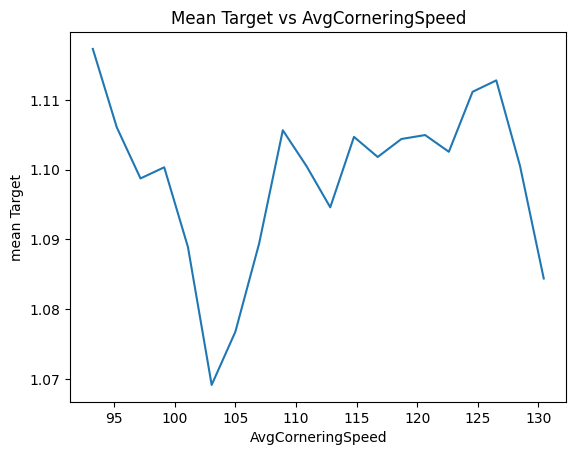

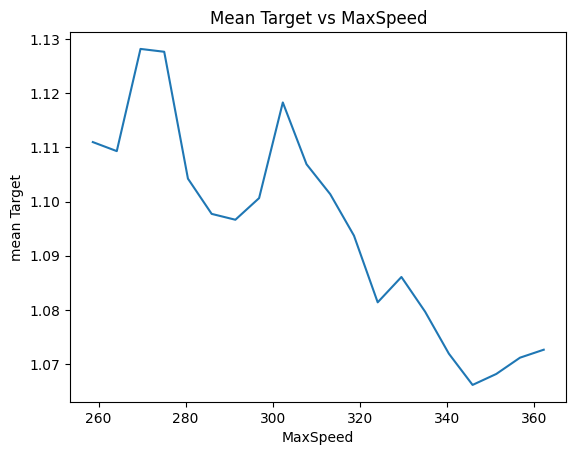

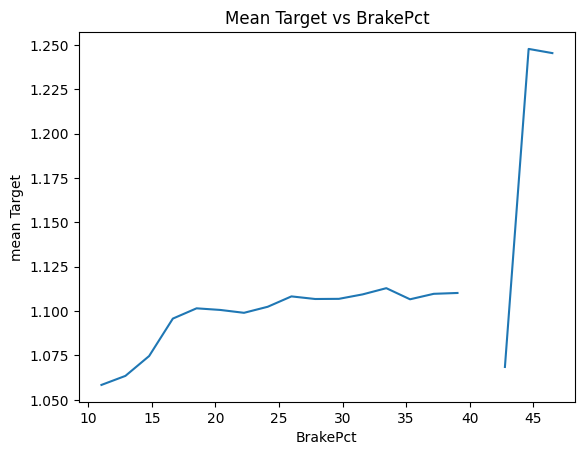

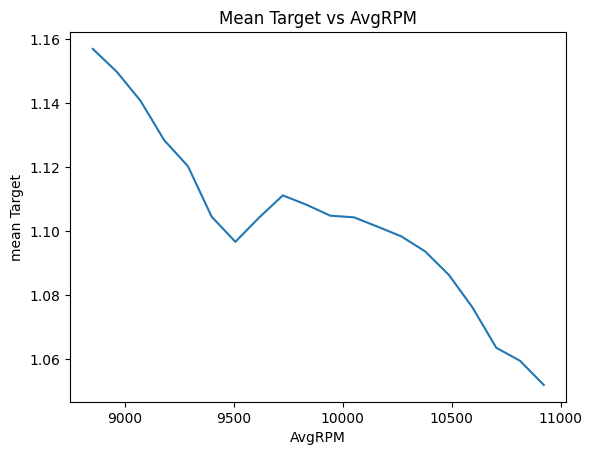

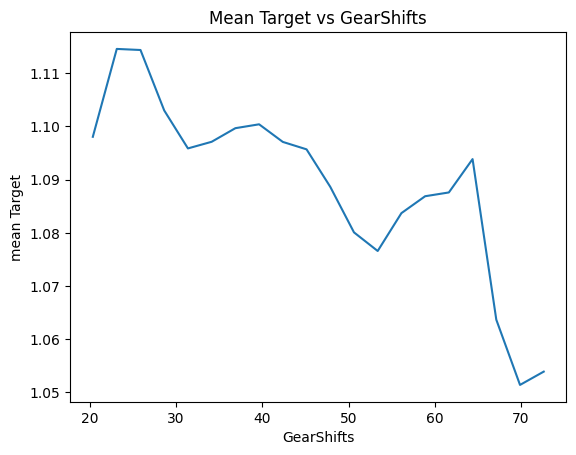

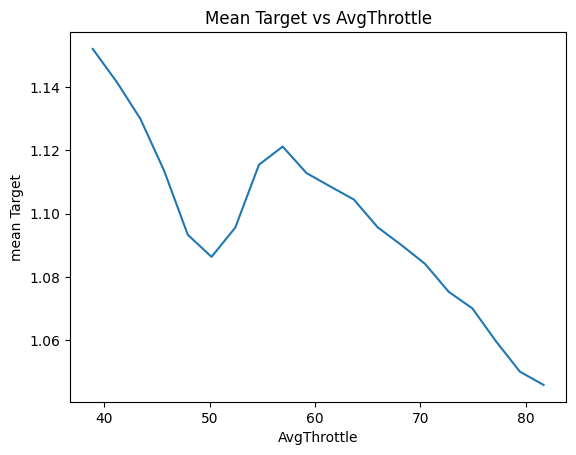

In [ ]:
def trend(df, xcol, ycol="Target", bins=20, title=None):
    b = pd.cut(df[xcol], bins=bins)
    g = df.groupby(b, observed=False)[ycol].agg(["mean","count"])
    x = b.cat.categories.mid

    plt.figure()
    plt.plot(x, g["mean"].values)
    plt.title(f"Mean {ycol} vs {xcol}")
    plt.xlabel(xcol)
    plt.ylabel(f"mean {ycol}")
    plt.show()


trend(df_agg_train, "AvgCorneringSpeed")
trend(df_agg_train, "MaxSpeed")
trend(df_agg_train, "BrakePct")
trend(df_agg_train, "AvgRPM")
trend(df_agg_train, "GearShifts")
trend(df_agg_train, "AvgThrottle") 

In [ ]:
tel = df_agg.copy()

df_train = df_train.merge(tel, how='left', on=['RoundNumber', 'LapNumber', 'DriverNumber'])
df_test = df_test.merge(tel, how='left', on=['RoundNumber', 'LapNumber', 'DriverNumber'])

df_train.shape

(16202, 31)

In [ ]:
df_train_imputed = df_train.copy()
df_train = df_train.dropna()

In [ ]:
impute_cols = [
    'RoundNumber', 'LapNumber', 'DriverNumber',  
    'TyreLife', 'TrackTemp', 'FuelLevel', 'SpeedST',                
    'AvgCorneringSpeed', 'AvgRPM', 'AvgThrottle', 'BrakePct' 
]

imputer = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=15, 
    random_state=42,
    verbose=0
)

data_to_impute = df_train_imputed[impute_cols].copy()

imputed_matrix = imputer.fit_transform(data_to_impute)

df_train_imputed[impute_cols] = imputed_matrix

In [ ]:
def eval_model(df_train, df_test, col_to_drop, model):
    X_train = df_train.drop(columns=col_to_drop)
    X_test = df_test.drop(columns=col_to_drop)
    y_train = df_train['Target']
    y_test = df_test['Target']
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'MAE on target: {mean_absolute_error(y_test, y_pred)}')
    y_pred = y_pred * df_test['QualiBest']
    mae = mean_absolute_error(df_test['LapTime'], y_pred)
    mape = mean_absolute_percentage_error(df_test['LapTime'], y_pred)
    print(f'MAE: {mae}')
    print(f'MAPE: {mape}')
    return df_test['LapTime'], y_pred

In [ ]:
df_train.shape

(16179, 31)

In [ ]:
col_to_drop = ['LapTime', 'DriverNumber', 'RoundNumber', 'LapNumber', 'Target', 'QualiBest']
model = RandomForestRegressor(
    n_estimators=100, 
    min_samples_leaf=25,
    max_depth=15,
    n_jobs=-1,
    max_features='sqrt',
    random_state=42
)
print('--- Model with imputed data ---')
_, _ = eval_model(df_train_imputed, df_test, col_to_drop, model)
print('--- Model with deleted ---')
y_test, y_pred = eval_model(df_train, df_test, col_to_drop, model)

--- Model with imputed data ---
MAE on target: 0.010005724016365984
MAE: 0.7504684759841184
MAPE: 0.009228860514279102
--- Model with deleted ---
MAE on target: 0.008821717876448091
MAE: 0.6640648186264189
MAPE: 0.008123190885488397


In [ ]:
full_df = pd.concat([df_train, df_test], axis=0)

# Final model

In [ ]:
col_to_drop = ['LapTime', 'DriverNumber', 'RoundNumber', 'LapNumber', 'Target', 'QualiBest']

X_train_full = df_train_imputed.drop(columns=col_to_drop)
y_train_full = df_train_imputed['Target']
X_test = df_test.drop(columns=col_to_drop).reindex(columns=X_train_full.columns, fill_value=0)

final_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
)
final_pipe.fit(X_train_full, y_train_full)

y_test_pred = final_pipe.predict(X_test)
lt_test_pred = y_test_pred * df_test['QualiBest'].values

mae_final = mean_absolute_error(df_test['LapTime'], lt_test_pred)
mape_final = mean_absolute_percentage_error(df_test['LapTime'], lt_test_pred)
print(f'Final MAE: {mae_final:.4f} s, MAPE: {mape_final:.4f}')

Final MAE: 0.7249 s, MAPE: 0.0088


In [ ]:
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

col_to_drop = ['LapTime', 'Target', 'RoundNumber']
train = full_df.dropna(subset=["Target", "QualiBest", "LapTime", "RoundNumber"]).copy()

X = train.drop(columns=col_to_drop, errors="ignore")
X = X.select_dtypes(include=[np.number])

y_ratio = train["Target"].to_numpy()
groups = train["RoundNumber"].to_numpy()

true_sec = train["LapTime"].to_numpy()
qb_all = train["QualiBest"].to_numpy()

logo = LeaveOneGroupOut()

oof_base_sec = np.empty(len(train), dtype=float)

for tr_idx, va_idx in logo.split(X, y_ratio, groups):
    mean_tr = y_ratio[tr_idx].mean()
    qb_va = qb_all[va_idx]
    oof_base_sec[va_idx] = mean_tr * qb_va

print("BASELINE LOGO MAE [s]:", mean_absolute_error(true_sec, oof_base_sec))

model = make_pipeline(
    SimpleImputer(strategy="median"),
    GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )
)

oof_model_sec = np.empty(len(train), dtype=float)

for tr_idx, va_idx in logo.split(X, y_ratio, groups):
    m = make_pipeline(
        SimpleImputer(strategy="median"),
        GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        )
    )
    m.fit(X.iloc[tr_idx], y_ratio[tr_idx])
    pred_ratio = m.predict(X.iloc[va_idx])
    oof_model_sec[va_idx] = pred_ratio * qb_all[va_idx]

print("MODEL LOGO MAE [s]:", mean_absolute_error(true_sec, oof_model_sec))

BASELINE LOGO MAE [s]: 2.0582452958204773
MODEL LOGO MAE [s]: 1.3335606843059336
